In [4]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display
import csv
import geopy
from pathlib import Path  
import sys
from bs4 import BeautifulSoup
import urllib
import json
import ast
import time
import geopandas as gpd

import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amer_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Authentication
consumerKey = "jLsJDtWU8yD5tZlcmwlzYnGjj"
consumerSecret = "Y236WRUhs5ylGfcZwjmabwPRWwedThHVB8gFVBPC3oTNAbRnCz"
accessToken = "964316780993933313-ZJOdE1MRMA8WyqZoNajtj0EWy4KQVDI"
accessTokenSecret = "qMOuqbyZmKXQTVXGFofwriLZpZn5zAAwGjsw0Wlft7M0a"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit = True)
file_dir = Path.cwd()

In [3]:

# The below function takes a given state, and returns a dataframe with every county and its corresponding square milage
def county_sqFootage(state):
	state = re.sub(' ', '-', state)
	url = urllib.request.urlopen('http://www.usa.com/rank/' +state.lower() + '-state--land-area--county-rank.htm')
	path = url.read()
	# empty list
	data = []
	# for getting the header from
	# the HTML file
	list_header = []
	soup = BeautifulSoup((path),'html.parser')
	header = soup.find_all("table")[1].find("tr")
	for items in header:
		try:
			list_header.append(items.get_text())
		except:
			continue
	# for getting the data
	HTML_data = soup.find_all("table")[1].find_all("tr")[1:]
	for element in HTML_data:
		sub_data = []
		for sub_element in element:
			try:
				sub_data.append(sub_element.get_text())
			except:
				continue
		data.append(sub_data)
	# Storing the data into Pandas
	# DataFrame
	df = pd.DataFrame(data = data, columns = list_header)
	df.drop(df.columns[[0]],axis = 1,inplace = True)
	df.rename(columns = {'County / Population':'County','Land Area ▼':'Area'}, inplace = True)
	# Removing the section of the data for population information and deleting it
	formatdf= df['County'].str.split(',',expand = True)
	formatdf = formatdf[0]
	# recombining the data
	df = df['Area'].str.split(' sq', expand = True)
	df = df.replace({',':''}, regex=True)	
	df = df[0]
	df= pd.concat([df,formatdf],axis=1,join = 'inner')
	df.columns = ['Area','County']
	df['County']=df['County'].str.upper()
	df['Radius'] = df['Area'].astype(float)
	df['Radius'] = df['Radius'].apply(lambda x: (x/3.1415)**.5)
	# Search Radius is what the Twitter API will end up using
	return df	

	# Main code logic copied from Codegeeks https://www.geeksforgeeks.org/convert-html-table-into-csv-file-in-python/

print(county_sqFootage('Texas'))

        Area     County     Radius
0    6183.73   BREWSTER  44.366659
1    4763.84      PECOS  38.941265
2    4570.98   HUDSPETH  38.144869
3    3855.23   PRESIDIO  35.031329
4    3812.79  CULBERSON  34.837976
..       ...        ...        ...
249   251.98     MORRIS   8.956009
250   229.45      RAINS   8.546248
251   195.83       CAMP   7.895344
252   186.46  SOMERVELL   7.704143
253   127.04   ROCKWALL   6.359189

[254 rows x 3 columns]


In [4]:
def create_wordcloud(text,keyword):
    file_path = os.path.join(file_dir, 'Keyword State')
    mask = np.array(Image.open('cloud.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    name = (state) + " on the term " + keyword+ ".png"
    path= os.path.join(file_path,name)
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    display(Image.open(path))

In [5]:

def getCountyInfo(state):
    
    csv_folder = 'State information'
    file_path = os.path.join(file_dir, csv_folder, (state+'.csv'))
    print((Path.cwd() / csv_folder /(state+'.csv')).exists())    
    if((Path.cwd() / csv_folder /(state+'.csv')).exists()):
        data = pd.read_csv(file_path)
    else:
        print('boop')
        # make a program that uses this dataset https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv
        # to get all the cities in a state
        data = pd.read_csv('https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv',sep='|')
        del data['State short'], data['City'],data['City alias']
        data.columns = data.columns.str.replace('State full', 'State')
        data = data[data.State == state]
        data.drop_duplicates(subset='County', keep='first', inplace=True)
        del data['State']
        coordinates = []
        for county in data['County']:
            print(county)
            locator = geopy.Photon(user_agent="myGeocoder")
            location = locator.geocode(county.lower() + ',' + state + ', United States')
            # Make a new column in my dataframe with the lat and long
            coordinates.append([location.latitude,location.longitude])
        data['Coordinates'] = coordinates
        area = county_sqFootage(state)
        data = pd.merge(data,area, on= 'County', how = 'outer')
        data.rename(columns = {'Area':'Area (sq/mi)','Radius':'Radius (mi)'}, inplace = True)
        data.to_csv(file_path)
    return data

print(getCountyInfo('Texas'))

True
     Unnamed: 0     County                 Coordinates  Area (sq/mi)  \
0             0     TRAVIS   [30.2878569, -97.7561392]        990.20   
1             1    SHERMAN  [36.2452294, -101.8858689]        923.03   
2             2     DALLAS   [32.7762719, -96.7968559]        871.28   
3             3     COLLIN   [33.1609629, -96.6060984]        841.22   
4             4     DENTON   [33.1838787, -97.1413417]        878.43   
..          ...        ...                         ...           ...   
249         249    EL PASO   [31.7754152, -106.464634]       1012.69   
250         250   BREWSTER  [29.8462742, -103.2400734]       6183.73   
251         251   HUDSPETH  [31.5388627, -105.4752945]       4570.98   
252         252   PRESIDIO  [29.9883766, -104.2336552]       3855.23   
253         253  CULBERSON   [31.4622625, -104.482834]       3812.79   

     Radius (mi)  
0      17.753866  
1      17.141127  
2      16.653685  
3      16.363879  
4      16.721878  
..           ...

In [78]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)
noOfTweet = 400
state = 'Texas'
countyDF =  (getCountyInfo(state))
keyword = 'Trump'
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
cityDict = {}
json_folder = 'Keyword State'
file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
def average(arr):
    return (sum(arr) / len(arr))
# extract the county collumn from the countyDF and convert its values to a list
countyList = countyDF['County'].values.tolist()
usefulTweets = 0
users = []
county_needed = []
# if file_path exists, set the county_needed list equal to all the items from the county list not present in the keys of the json
total_data = []
if((Path.cwd() / json_folder /(((state) + " on the term " + keyword +'.json'))).exists()):
    f = open(file_path, 'r')
    cityDict = json.load(f)
    checked_counties = cityDict.keys()
    # set county_needed equal to the items in county that aren't present in checked_counties
    county_needed = countyList-checked_counties
    print(county_needed)
    for county in cityDict:
        tweet_list = tweet_list + cityDict[county][2]
    print(len(tweet_list))


else:
    county_needed = countyList
for county in county_needed:
    coordinates = (countyDF.loc[countyDF['County'] == county]['Coordinates'])
    coordinates = np.array(coordinates.values.tolist())[0]
    coordinates = ast.literal_eval(coordinates)
    lat = coordinates[0]
    longi = coordinates[1]
    miles = [countyDF.loc[countyDF['County'] == county]['Radius (mi)'].values[0]][0]
    geocode = str(coordinates[0]) + ',' + str(coordinates[1]) + ',' + str(miles) + 'mi'
    backoff_counter = 1
    while True:
        try:
            tweets = tweepy.Cursor(api.search_tweets, q=keyword,geocode = geocode).items(noOfTweet)
            break
        except tweepy.TweepError as e:
            print(e.reason)
            sleep(60*backoff_counter)
            backoff_counter += 1
            continue
    location = county
    tweet_list_county = []
    if location not in cityDict.keys():
        cityDict[location] = [1,[],[]]
    for tweet in tweets:
        # location = tweet.user.location
        
        username = tweet.user.id
        # location = (location.replace(', TX', '')).lower()
        cityDict[location][0]+=1
            
        tweet_list.append(tweet.text)
        analysis = TextBlob(tweet.text)
        score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        if (username not in users) and (tweet not in tweet_list):
            tweet_list_county.append(tweet.text)
            usefulTweets+=1
            polarity += analysis.sentiment.polarity
            cityDict[location][1].append(comp)
            if neg > pos:
                negative_list.append(tweet.text)
                negative += 1
            elif pos > neg:
                positive_list.append(tweet.text)
                positive += 1
            
            elif pos == neg:
                neutral_list.append(tweet.text)
                neutral += 1
            users.append(username)
            # Keep track of unique tweets per city
        # cityDict[location][2].append(tweet_list_county)
        # save the cityDict to a json file at directory file_path
        with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
        
    print("For the county of " + str(county) + ", there were " + str(cityDict[location][0]) + " unique tweets")
for city in countyList:
    cityDict[city].pop(2)
    if(len(cityDict[city][1]) > 0):
        cityDict[city][1] = sum(cityDict[city][1])/len(cityDict[city][1])
    else:
        print(city)
        cityDict.pop(city)
    
    # delete the second index of cityDIct
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
# fully expand all lower levels of the list to the first level
tweet_list = list(set(tweet_list))
print(len(tweet_list))
with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
# make a new dictionary identical to countyDict but without the second index



True
For the county of TRAVIS, there were 401 unique tweets
For the county of SHERMAN, there were 1 unique tweets
For the county of DALLAS, there were 401 unique tweets
For the county of COLLIN, there were 401 unique tweets
For the county of DENTON, there were 267 unique tweets
For the county of GRAYSON, there were 30 unique tweets
For the county of ROCKWALL, there were 57 unique tweets
For the county of ELLIS, there were 63 unique tweets
For the county of NAVARRO, there were 2 unique tweets
For the county of VAN ZANDT, there were 6 unique tweets
For the county of KAUFMAN, there were 39 unique tweets
For the county of HENDERSON, there were 5 unique tweets
For the county of HUNT, there were 172 unique tweets
For the county of WOOD, there were 7 unique tweets
For the county of LAMAR, there were 23 unique tweets
For the county of RED RIVER, there were 1 unique tweets
For the county of FANNIN, there were 3 unique tweets
For the county of DELTA, there were 1 unique tweets


Rate limit reached. Sleeping for: 130


For the county of HOPKINS, there were 10 unique tweets
For the county of RAINS, there were 1 unique tweets
For the county of CAMP, there were 1 unique tweets
For the county of TITUS, there were 3 unique tweets
For the county of FRANKLIN, there were 3 unique tweets
For the county of BOWIE, there were 26 unique tweets
For the county of CASS, there were 6 unique tweets
For the county of MARION, there were 1 unique tweets
For the county of MORRIS, there were 1 unique tweets
For the county of GREGG, there were 11 unique tweets
For the county of PANOLA, there were 8 unique tweets
For the county of UPSHUR, there were 1 unique tweets
For the county of HARRISON, there were 17 unique tweets
For the county of RUSK, there were 2 unique tweets
For the county of SMITH, there were 59 unique tweets
For the county of CHEROKEE, there were 22 unique tweets
For the county of NACOGDOCHES, there were 140 unique tweets
For the county of ANDERSON, there were 5 unique tweets
For the county of LEON, there were 

Rate limit reached. Sleeping for: 817


For the county of CLAY, there were 238 unique tweets
For the county of MONTAGUE, there were 1 unique tweets
For the county of COOKE, there were 9 unique tweets
For the county of WICHITA, there were 48 unique tweets
For the county of ARCHER, there were 238 unique tweets
For the county of KNOX, there were 1 unique tweets
For the county of WILBARGER, there were 2 unique tweets
For the county of YOUNG, there were 1 unique tweets
For the county of BAYLOR, there were 1 unique tweets
For the county of HASKELL, there were 7 unique tweets
For the county of ERATH, there were 3 unique tweets
For the county of STEPHENS, there were 1 unique tweets
For the county of JACK, there were 1 unique tweets
For the county of SHACKELFORD, there were 2 unique tweets
For the county of BROWN, there were 2 unique tweets
For the county of EASTLAND, there were 18 unique tweets
For the county of HAMILTON, there were 1 unique tweets
For the county of COMANCHE, there were 1 unique tweets
For the county of CALLAHAN, th

Rate limit reached. Sleeping for: 817


For the county of HARRIS, there were 401 unique tweets
For the county of FORT BEND, there were 201 unique tweets
For the county of MONTGOMERY, there were 401 unique tweets
For the county of WALKER, there were 401 unique tweets
For the county of LIBERTY, there were 66 unique tweets
For the county of SAN JACINTO, there were 3 unique tweets
For the county of GRIMES, there were 65 unique tweets
For the county of HARDIN, there were 22 unique tweets
For the county of MATAGORDA, there were 3 unique tweets
For the county of COLORADO, there were 3 unique tweets
For the county of AUSTIN, there were 401 unique tweets
For the county of WHARTON, there were 6 unique tweets
For the county of BRAZORIA, there were 43 unique tweets
For the county of WALLER, there were 108 unique tweets
For the county of WASHINGTON, there were 8 unique tweets


Rate limit reached. Sleeping for: 779


For the county of GALVESTON, there were 200 unique tweets
For the county of CHAMBERS, there were 9 unique tweets
For the county of ORANGE, there were 43 unique tweets
For the county of JEFFERSON, there were 11 unique tweets
For the county of BRAZOS, there were 71 unique tweets
For the county of BURLESON, there were 3 unique tweets
For the county of LEE, there were 21 unique tweets
For the county of VICTORIA, there were 11 unique tweets
For the county of REFUGIO, there were 5 unique tweets
For the county of DE WITT, there were 1 unique tweets
For the county of JACKSON, there were 1 unique tweets
For the county of GOLIAD, there were 1 unique tweets
For the county of LAVACA, there were 2 unique tweets
For the county of CALHOUN, there were 8 unique tweets
For the county of LA SALLE, there were 1 unique tweets
For the county of BEXAR, there were 401 unique tweets
For the county of BANDERA, there were 54 unique tweets
For the county of KENDALL, there were 20 unique tweets
For the county of F

Rate limit reached. Sleeping for: 802


For the county of CAMERON, there were 41 unique tweets
For the county of STARR, there were 167 unique tweets
For the county of WILLACY, there were 5 unique tweets
For the county of BASTROP, there were 27 unique tweets
For the county of BURNET, there were 8 unique tweets
For the county of BLANCO, there were 19 unique tweets
For the county of HAYS, there were 124 unique tweets
For the county of CALDWELL, there were 64 unique tweets
For the county of GILLESPIE, there were 9 unique tweets
For the county of UVALDE, there were 10 unique tweets
For the county of DIMMIT, there were 1 unique tweets
For the county of ZAVALA, there were 19 unique tweets
For the county of KINNEY, there were 34 unique tweets
For the county of REAL, there were 1 unique tweets
For the county of VAL VERDE, there were 1 unique tweets
For the county of TERRELL, there were 1 unique tweets
For the county of MAVERICK, there were 5 unique tweets
For the county of FAYETTE, there were 13 unique tweets
For the county of OLDHAM

Rate limit reached. Sleeping for: 814


For the county of NOLAN, there were 2 unique tweets
For the county of TAYLOR, there were 59 unique tweets
For the county of HOWARD, there were 6 unique tweets
For the county of MITCHELL, there were 3 unique tweets
For the county of SCURRY, there were 1 unique tweets
For the county of KENT, there were 1 unique tweets
For the county of FISHER, there were 2 unique tweets
For the county of MIDLAND, there were 100 unique tweets
For the county of MARTIN, there were 1 unique tweets
For the county of ANDREWS, there were 1 unique tweets
For the county of REEVES, there were 2 unique tweets
For the county of WARD, there were 1 unique tweets
For the county of PECOS, there were 1 unique tweets
For the county of CRANE, there were 2 unique tweets
For the county of JEFF DAVIS, there were 1 unique tweets
For the county of BORDEN, there were 2 unique tweets
For the county of GLASSCOCK, there were 1 unique tweets
For the county of ECTOR, there were 63 unique tweets
For the county of WINKLER, there were 1

In [79]:


positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
print(cityDict)
print('---')
# remove duplicates from tweet_list
# Function got too chambers before hitting rate limit

{'TRAVIS': [401, 0.013483265306122469], 'DALLAS': [401, -0.062243951612903206], 'COLLIN': [401, -0.01901180124223603], 'DENTON': [267, -0.03451098901098901], 'GRAYSON': [30, -0.059283333333333334], 'ROCKWALL': [57, -0.11156666666666669], 'ELLIS': [63, 0.007096969696969698], 'NAVARRO': [2, 0.4019], 'VAN ZANDT': [6, -0.31575000000000003], 'KAUFMAN': [39, -0.09417500000000001], 'HENDERSON': [5, 0.49187499999999995], 'HUNT': [172, 0.007816666666666666], 'WOOD': [7, -0.4321], 'LAMAR': [23, 0.15338], 'FANNIN': [3, 0.0], 'HOPKINS': [10, -0.43594], 'BOWIE': [26, 0.09766923076923076], 'CASS': [6, -0.06539999999999999], 'GREGG': [11, -0.08837142857142857], 'PANOLA': [8, -0.14759999999999998], 'HARRISON': [17, -0.24405], 'RUSK': [2, 0.0], 'SMITH': [59, -0.05230000000000002], 'CHEROKEE': [22, -0.023424999999999994], 'NACOGDOCHES': [140, 0.03384749999999999], 'ANDERSON': [5, 0.0], 'TRINITY': [3, 0.0], 'HOUSTON': [401, -0.012533082706766925], 'ANGELINA': [128, -0.2557], 'NEWTON': [3, -0.058699999999

In [80]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  8243
positive number:  1237
negative number:  1355
neutral number:  1096


In [81]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(tweet_list.shape[0])

,0,text
0,@DonLew87 Trump 😆,trump
1,Tangible gains made by Biden in the first 9 mo...,tangible gains made by biden in the first 9 mo...
2,"@Myberns1 I never voted for Trump, I never wen...",i never voted for trump i never went huntin...
3,I want every apology in the book after watchin...,i want every apology in the book after watchin...
4,@Mcsjr454Mikey @WarTornTrump @NickDone8 @Pamel...,
...,...,...
8238,@BradHuston Biden to Pfizer: if you delay anno...,biden to pfizer if you delay announcing tha...
8239,@BigHeartedGuy She survived trump. That’s wors...,she survived trump that s worse than the pl...
8240,@CamSpradling @MarkMyersOK @tcblume Stitt shou...,stitt should have his dna tested acts j...
8241,@weenell3 He virtually gave the same speech as...,he virtually gave the same speech as trump a...


In [82]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
        tw_list.loc[index, 'neg'] = neg
        tw_list.loc[index, 'neu'] = neu
        tw_list.loc[index, 'pos'] = pos
        tw_list.loc[index, 'compound'] = comp
tw_list.head(10)
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [83]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
negative,3091,37.50
positive,2722,33.02
neutral,2430,29.48


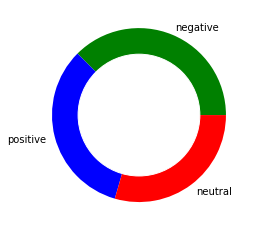

In [84]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Word Cloud Saved Successfully


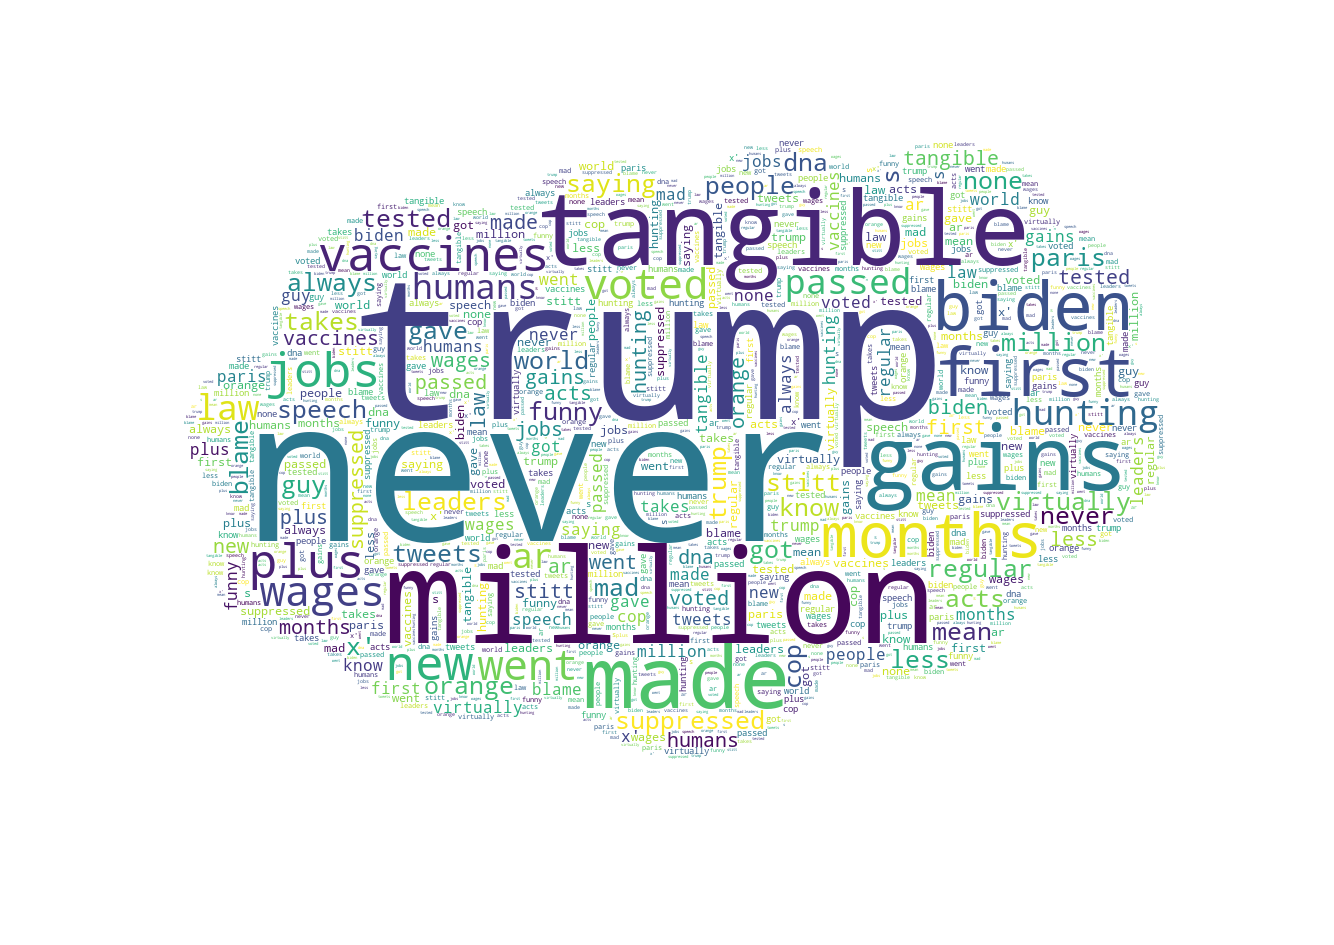

In [85]:
cloud = create_wordcloud(tw_list['text'].values,keyword)
# save the wordcloud image


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


0      0.013483
1     -0.062244
2     -0.019012
3     -0.034511
4     -0.059283
         ...   
136    0.502300
137   -0.715900
138   -0.022939
139   -0.371500
140   -0.252991
Name: score, Length: 141, dtype: float64
  STATE_NAME    County                                           geometry  \
0      Texas  ANDERSON  POLYGON ((-95.43775 31.87088, -95.43778 31.870...   
1      Texas   ANDREWS  POLYGON ((-102.36617 32.52333, -102.36102 32.5...   
2      Texas  ANGELINA  POLYGON ((-94.86491 31.52074, -94.86462 31.520...   
3      Texas   ARANSAS  MULTIPOLYGON (((-97.04711 27.86663, -97.04747 ...   
4      Texas    ARCHER  POLYGON ((-98.42344 33.83594, -98.42367 33.830...   

   # of Tweets   score  
0          5.0  0.0000  
1          NaN     NaN  
2        128.0 -0.2557  
3          NaN     NaN  
4          NaN     NaN  


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


TypeError: 'norm' must be an instance of matplotlib.colors.Normalize or None, not a type

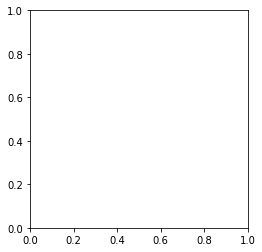

In [15]:
from matplotlib import colors
import matplotlib.cm as cm
# state = 'California'
# keyword = 'Transgender'
json_folder = 'Keyword State'
state  ='Texas'
keyword ='Trump'
file_dir = Path.cwd()
file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))

shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
name = ((state) + " on the term " + keyword +'.json')
data_loc = os.path.join(file_dir, 'Keyword State', name)
unitedStates = gpd.read_file(shape_dir)
unitedStates = unitedStates[['STATE_NAME','NAME','geometry']].copy()
unitedStates = unitedStates[unitedStates.STATE_NAME == state]
unitedStates['NAME'] = unitedStates['NAME'].str.upper()
unitedStates.rename(columns={'NAME':'County'}, inplace=True)
# Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
f = open(file_path, 'r')
state_dict = json.load(f)
stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
stateDF.reset_index(inplace=True)
stateDf  = stateDF.copy()
stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score'}, inplace=True)
print(stateDF['score'])

unitedStates = pd.merge(unitedStates,stateDF, on= 'County', how = 'outer')
print(unitedStates.head())
cm1 = colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
norm = colors.TwoSlopeNorm(vmin=-.6, vcenter=0, vmax=.6)
ax = unitedStates.plot(cmap = cm1, norm= norm,edgecolor='black',column = 'score',legend = True, legend_kwds={'label':'Sentiment Score','orientation':'vertical'})
title = (state + " on the term \"" + keyword +"\"")
ax.set_title(title)
ax.set_axis_off()   
save_dir=os.path.join(file_dir, 'Maps', state)

if(os.path.isdir(save_dir)):
    save_name = os.path.join(file_dir, 'Maps', state,keyword +'.png')
else:
    # make a directory in the maps folder with the name of the given state
    os.mkdir(save_dir)
    save_name = os.path.join(file_dir, 'Maps', state,keyword +'.png')
# save the figure to the maps folder inside the folder corresponding to the state

plt.savefig(save_name,dpi=300,facecolor='white', transparent=False)

